In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [2]:

class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.01):
        self.layers = layers
        self.learning_rate = learning_rate
        self.parameters = {}
        self.cache = {}
        self.grads = {}
        
        # Initialize weights and biases
        for l in range(1, len(layers)):
            self.parameters[f'W{l}'] = np.random.randn(layers[l], layers[l-1]) * 0.1
            self.parameters[f'b{l}'] = np.zeros((layers[l], 1))
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))  # Clip for numerical stability
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward_propagation(self, X):
        self.cache['A0'] = X.T  # Transpose for correct dimensions
        
        for l in range(1, len(self.layers)):
            Z = np.dot(self.parameters[f'W{l}'], self.cache[f'A{l-1}']) + self.parameters[f'b{l}']
            
            if l == len(self.layers) - 1:  # Output layer
                A = self.sigmoid(Z)
            else:  # Hidden layers
                A = np.tanh(Z)  # Using tanh for hidden layers
            
            self.cache[f'Z{l}'] = Z
            self.cache[f'A{l}'] = A
        
        return self.cache[f'A{len(self.layers)-1}']
    
    def compute_cost(self, AL, Y):
        m = Y.shape[0]
        cost = (-1/m) * np.sum(Y * np.log(AL.T + 1e-8) + (1 - Y) * np.log(1 - AL.T + 1e-8))
        return np.squeeze(cost)
    
    def backward_propagation(self, X, Y):
        m = X.shape[0]
        L = len(self.layers) - 1
        
        # Output layer gradient
        dAL = - (np.divide(Y.T, self.cache[f'A{L}'] + 1e-8) - np.divide(1 - Y.T, 1 - self.cache[f'A{L}'] + 1e-8))
        dZ = dAL * self.sigmoid_derivative(self.cache[f'A{L}'])
        
        self.grads[f'dW{L}'] = (1/m) * np.dot(dZ, self.cache[f'A{L-1}'].T)
        self.grads[f'db{L}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        
        # Hidden layers gradients
        for l in reversed(range(1, L)):
            dA_prev = np.dot(self.parameters[f'W{l+1}'].T, dZ)
            dZ = dA_prev * (1 - np.power(self.cache[f'A{l}'], 2))  # tanh derivative
            
            self.grads[f'dW{l}'] = (1/m) * np.dot(dZ, self.cache[f'A{l-1}'].T)
            self.grads[f'db{l}'] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
    
    def update_parameters(self):
        for l in range(1, len(self.layers)):
            self.parameters[f'W{l}'] -= self.learning_rate * self.grads[f'dW{l}']
            self.parameters[f'b{l}'] -= self.learning_rate * self.grads[f'db{l}']
    
    def train(self, X, Y, epochs=1000, verbose=True):
        costs = []
        
        for i in range(epochs):
            # Forward propagation
            AL = self.forward_propagation(X)
            
            # Compute cost
            cost = self.compute_cost(AL, Y)
            costs.append(cost)
            
            # Backward propagation
            self.backward_propagation(X, Y)
            
            # Update parameters
            self.update_parameters()
            
            if verbose and i % 100 == 0:
                print(f"Epoch {i}, Cost: {cost:.4f}")
        
        return costs
    
    def predict(self, X, threshold=0.5):
        AL = self.forward_propagation(X)
        predictions = (AL.T > threshold).astype(int)
        return predictions
    
    def predict_proba(self, X):
        AL = self.forward_propagation(X)
        return AL.T



In [3]:
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=8,
    n_redundant=2,
    n_clusters_per_class=1,
    random_state=42
)

In [4]:


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


nn = NeuralNetwork(layers=[10, 8, 4, 1], learning_rate=0.01)
costs = nn.train(X_train, y_train.reshape(-1, 1), epochs=1000)


y_pred = nn.predict(X_test)
y_pred_proba = nn.predict_proba(X_test)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Epoch 0, Cost: 0.6921
Epoch 100, Cost: 0.6907
Epoch 200, Cost: 0.6888
Epoch 300, Cost: 0.6861
Epoch 400, Cost: 0.6814
Epoch 500, Cost: 0.6729
Epoch 600, Cost: 0.6564
Epoch 700, Cost: 0.6233
Epoch 800, Cost: 0.5627
Epoch 900, Cost: 0.4748

Accuracy: 0.9200

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92       102
           1       0.87      0.99      0.92        98

    accuracy                           0.92       200
   macro avg       0.93      0.92      0.92       200
weighted avg       0.93      0.92      0.92       200



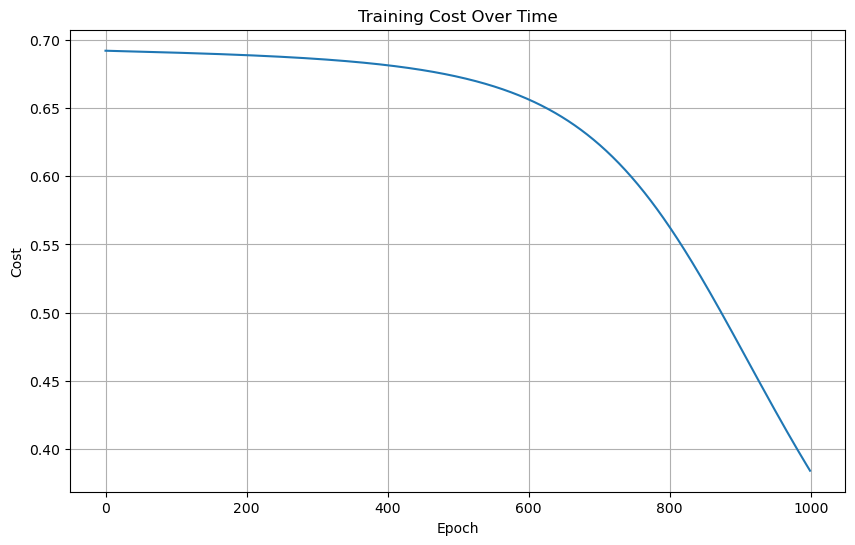

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(costs)
plt.title('Training Cost Over Time')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.grid(True)
plt.show()